In [1]:
import numpy as np
import matplotlib.pyplot as plt

4.5 計算例

4.5.1 衝撃波管問題

In [10]:
def get_U_parameters_1(rho, u, v, w, Bx, By, Bz, e, pT_1, S, SM):
    u1 = SM
    v1 = v - Bx * By * (SM - u) / (rho * (S - u) * (S - SM) - Bx**2)
    w1 = w - Bz * By * (SM - u) / (rho * (S - u) * (S - SM) - Bx**2)
    Bx1 = Bx #1次元だからこれでいいはず
    By1 = By * (rho * (S - u)**2 - Bx**2) / (rho * (S - u) * (S - SM) - Bx**2)
    Bz1 = Bz * (rho * (S - u)**2 - Bx**2) / (rho * (S - u) * (S - SM) - Bx**2)
    e1 = ((S - u) * e - pT_1 * u + pT_1 * SM + Bx * ((u*Bx + v*By + w*Bz) - (u1*Bx1 + v1*By1 + w1*Bz1))) / (S - SM)
    return u1, v1, w1, Bx1, By1, Bz1, e1


def get_U_parameters_2(rho1_L, rho1_R, u1_L, u1_R, v1_L, v1_R, w1_L, w1_R, Bx1_L, Bx1_R, By1_L, By1_R, Bz1_L, Bz1_R, e1_L, e1_R, SM):
    u2 = SM
    Bx2 = Bx1_L #1次元だからこれでいいはず
    v2 = (np.sqrt(rho1_L)*v1_L + np.sqrt(rho1_R)*v1_R + (By1_R - By1_L)*np.sign(Bx2)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    w2 = (np.sqrt(rho1_L)*w1_L + np.sqrt(rho1_R)*w1_R + (Bz1_R - Bz1_L)*np.sign(Bx2)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    By2 = (np.sqrt(rho1_L)*By1_R + np.sqrt(rho1_R)*By1_L + np.sqrt(rho1_L*rho1_R)*(v1_R - v1_L)*np.sign(Bx2)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    Bz2 = (np.sqrt(rho1_L)*Bz1_R + np.sqrt(rho1_R)*Bz1_L + np.sqrt(rho1_L*rho1_R)*(w1_R - w1_L)*np.sign(Bx2)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    e2_L = e1_L - np.sqrt(rho1_L) * ((u1_L*Bx1_L + v1_L*By1_L + w1_L*Bz1_L) - (u2*Bx2 + v2*By2 + w2*Bz2)) * np.sign(Bx2)
    e2_R = e1_R - np.sqrt(rho1_R) * ((u1_R*Bx1_R + v1_R*By1_R + w1_R*Bz1_R) - (u2*Bx2 + v2*By2 + w2*Bz2)) * np.sign(Bx2)

    return u2, v2, w2, Bx2, By2, Bz2, e2_L, e2_R


def get_flux(rho, u, v, w, Bx, By, Bz, e, pT, F):
    F[:, 0] = rho * u
    F[:, 1] = rho * u**2 + pT - Bx**2
    F[:, 2] = rho * u * v - Bx * By
    F[:, 3] = rho * u * w - Bx * Bz 
    F[:, 4] = np.zeros(rho.shape)
    F[:, 5] = u * By - v * Bx
    F[:, 6] = u * Bz - w * Bx
    F[:, 7] = (e + pT) * u - Bx * (Bx*u + By*v + Bz*w)
    return F

In [83]:
dx = 0.01
dt = 0.0002
x = np.arange(0.0, 1.0, dx)
nmax = len(x)

gamma = 5.0/3.0

U = np.zeros([x.shape[0], 8]) # rho, rho*u, rho*v, rho*w, Bx, By, Bz, e
# ここでのLとRはメインループ内のL・Rの意味とは違う
# ここのは左半分・右半分の意味
rho_L_init = 1.0
rho_R_init = 0.125
velocity_L_init = np.array([0.0, 0.0, 0.0])
velocity_R_init = np.array([0.0, 0.0, 0.0])
B_L_init = np.array([0.75, 1.0, 0.0])
B_R_init = np.array([0.75, -1.0, 0.0])
p_L_init = 1.0
p_R_init = 0.1
U[x < 0.5, 0] = rho_L_init
U[x >= 0.5, 0] = rho_R_init
U[x < 0.5, 1:4] = rho_L_init * velocity_L_init
U[x >= 0.5, 1:4] = rho_R_init * velocity_R_init
U[x < 0.5, 4:7] = B_L_init
U[x >= 0.5, 4:7] = B_R_init
U[x < 0.5, 7] = p_L_init/(gamma-1) + rho_L_init * np.linalg.norm(velocity_L_init)**2/2 + np.linalg.norm(B_L_init)**2/2
U[x >= 0.5, 7] = p_R_init/(gamma-1) + rho_R_init * np.linalg.norm(velocity_R_init)**2/2 + np.linalg.norm(B_R_init)**2/2

F_L = np.zeros(U.shape)
F1_L = np.zeros(U.shape)
F2_L = np.zeros(U.shape)
F_R = np.zeros(U.shape)
F1_R = np.zeros(U.shape)
F2_R = np.zeros(U.shape)

In [84]:
step = 10
for t in range(step+1):
    rho_L = U[:, 0]
    u_L = U[:, 1] / rho_L
    v_L = U[:, 2] / rho_L
    w_L = U[:, 3] / rho_L
    Bx_L = U[:, 4]
    By_L = U[:, 5]
    Bz_L = U[:, 6]
    e_L = U[:, 7]
    rho_R = np.roll(rho_L, -1)
    u_R = np.roll(u_L, -1)
    v_R = np.roll(v_L, -1)
    w_R = np.roll(w_L, -1)
    Bx_R = np.roll(Bx_L, -1)
    By_R = np.roll(By_L, -1)
    Bz_R = np.roll(Bz_L, -1)
    e_R = np.roll(e_L, -1)
    p_L = (gamma-1) * (e_L - rho_L*(u_L**2+v_L**2+w_L**2)/2 - (Bx_L**2+By_L**2+Bz_L**2)/2)
    p_R = np.roll(p_L, -1)

    cs_L = np.sqrt(gamma*p_L/rho_L)
    cs_R = np.roll(cs_L, -1)
    ca_L = np.sqrt(Bx_L**2+By_L**2+Bz_L**2) / np.sqrt(rho_L)
    ca_R = np.roll(ca_L, -1)
    fast_Alfven_L = 1/np.sqrt(2) * (cs_L**2 + ca_L**2 + np.sqrt((cs_L**2+ca_L**2)**2 - 4 * cs_L**2 * ca_L**2))
    fast_Alfven_R = np.roll(fast_Alfven_L, -1)
    S_L = np.minimum(u_L, u_R) - np.maximum(fast_Alfven_L, fast_Alfven_R)
    S_R = np.minimum(u_L, u_R) + np.maximum(fast_Alfven_L, fast_Alfven_R)

    pT_L = p_L + (Bx_L**2+By_L**2+Bz_L**2)/2
    pT_R = np.roll(pT_L, -1)

    SM = ((S_R - u_R)*rho_R*u_R - (S_L - u_L)*rho_L*u_L - pT_R + pT_L) / ((S_R - u_R)*rho_R - (S_L - u_L)*rho_L)
    pT1 = ((S_R - u_R)*rho_R*pT_L - (S_L - u_L)*rho_L*pT_R + rho_L*rho_R*(S_R - u_R)*(S_L - u_L)*(u_R - u_L)) / ((S_R - u_R)*rho_R - (S_L - u_L)*rho_L)
    pT1_L = pT1 
    pT1_R = np.roll(pT1, -1)
    rho1_L = rho_L * (S_L - u_L) / (S_L - SM)
    rho1_R = rho_R * (S_R - u_R) / (S_R - SM)
    u1_L, v1_L, w1_L, Bx1_L, By1_L, Bz1_L, e1_L = get_U_parameters_1(rho_L, u_L, v_L, w_L, Bx_L, By_L, Bz_L, e_L, pT1, S_L, SM)
    u1_R, v1_R, w1_R, Bx1_R, By1_R, Bz1_R, e1_R = get_U_parameters_1(rho_R, u_R, v_R, w_R, Bx_R, By_R, Bz_R, e_R, pT1, S_R, SM)

    S_L1 = SM - np.abs(Bx_L)/np.sqrt(rho1_L) #Bxの扱いはどうする？　1次元だからこれでいいはず…
    S_R1 = SM + np.abs(Bx_L)/np.sqrt(rho1_R) #Bxの扱いはどうする？　1次元だからこれでいいはず…

    u2, v2, w2, Bx2, By2, Bz2, e2_L, e2_R = get_U_parameters_2(rho1_L, rho1_R, u1_L, u1_R, v1_L, v1_R, w1_L, w1_R, Bx1_L, Bx1_R, By1_L, By1_R, Bz1_L, Bz1_R, e1_L, e1_R, SM)
    pT2 = p_L + (Bx2**2+By2**2+Bz2**2)/2 #圧力は一定のスキーム（なはず）
    #rho2_L = (e2_L - p_L/(gamma-1) - (Bx2**2+By2**2+Bz2**2)/2) / ((u2**2+v2**2+w2**2)/2)
    #rho2_R = (e2_R - p_R/(gamma-1) - (Bx2**2+By2**2+Bz2**2)/2) / ((u2**2+v2**2+w2**2)/2)

    # Fの選択
    F_L = get_flux(rho_L, u_L, v_L, w_L, Bx_L, By_L, Bz_L, e_L, pT_L, F_L)
    F1_L = get_flux(rho1_L, u1_L, v1_L, w1_L, Bx1_L, By1_L, Bz1_L, e1_L, pT1_L, F1_L)
    F2_L = get_flux(rho1_L, u2, v2, w2, Bx2, By2, Bz2, e2_L, pT2, F2_L)
    F_R = get_flux(rho_R, u_R, v_R, w_R, Bx_R, By_R, Bz_R, e_R, pT_R, F_R)
    F1_R = get_flux(rho1_R, u1_R, v1_R, w1_R, Bx1_R, By1_R, Bz1_R, e1_R, pT1_R, F1_R)
    F2_R = get_flux(rho1_R, u2, v2, w2, Bx2, By2, Bz2, e2_R, pT2, F2_R)

    F = F_L.T * (S_L < 0) + F1_L.T * ((S_L <= 0) & (0 < S_L1)) + F2_L.T * ((S_L1 <= 0) & (0 < SM)) \
      + F_R.T * (S_R <= 0) + F1_R.T * ((S_R1 <= 0) & (0 < S_R)) + F2_R.T * ((SM <= 0) & (0 < S_R1))

    # 時間発展
    U += -dt/dx * (F.T - np.roll(F.T, 1, axis=1))

    # 対称境界条件
    U[0, :] = U[1, :]
    U[-1, :] = U[-2, :]

C:\Users\keita\AppData\Local\Temp\ipykernel_8356\412473234.py:22: RuntimeWarning: invalid value encountered in sqrt
  cs_L = np.sqrt(gamma*p_L/rho_L)


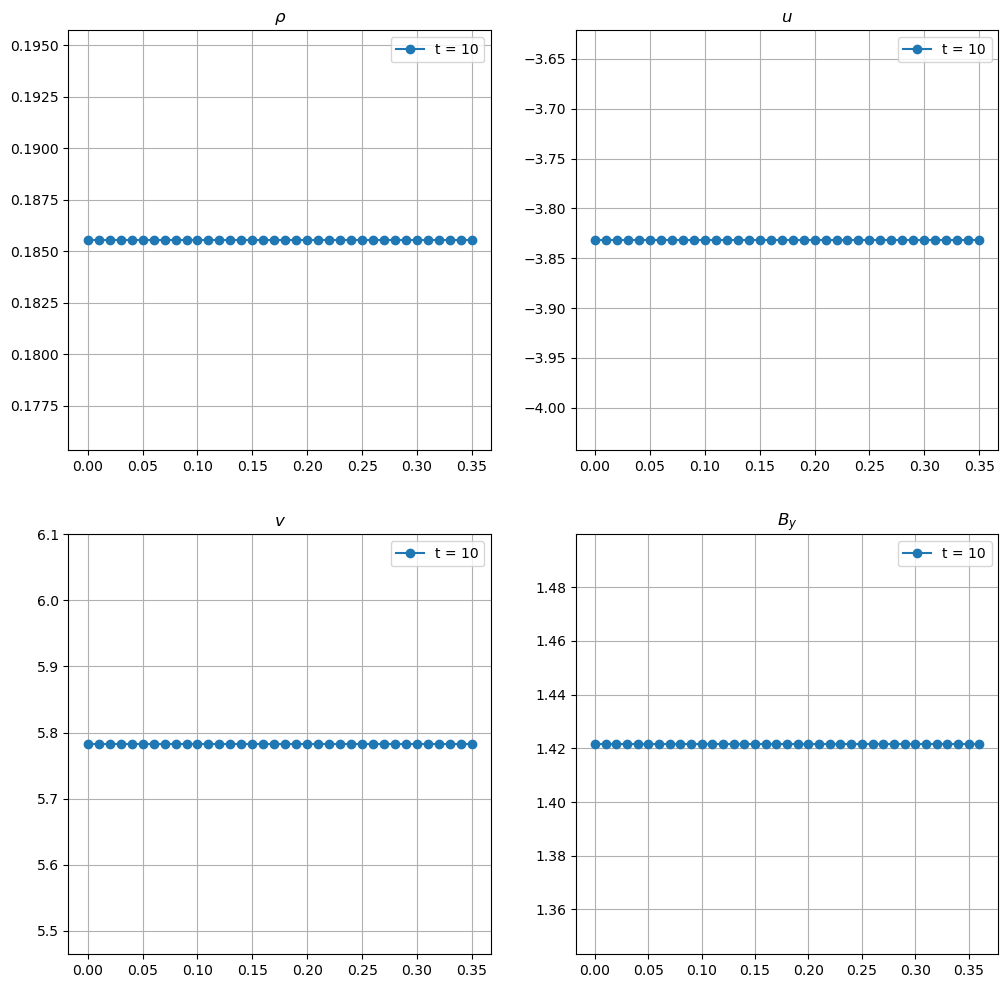

In [85]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

rho = U[:, 0]
u = U[:, 1] / rho 
v = U[:, 2] / rho 
w = U[:, 3] / rho 
Bx = U[:, 4]
By = U[:, 5]
Bz = U[:, 6]
e = U[:, 7]

ax1.plot(x, rho, marker='o', label=f't = {t}')
ax2.plot(x, u, marker='o', label=f't = {t}')
ax3.plot(x, v, marker='o', label=f't = {t}')
ax4.plot(x, By, marker='o', label=f't = {t}')

ax1.set_title(r"$\rho$")
ax2.set_title(r"$u$")
ax3.set_title(r"$v$")
ax4.set_title(r"$B_y$")
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')
plt.show()